In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pyod
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import roc_auc_score,roc_curve,auc
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [2]:
df=pd.read_csv("synthetic_weather_data_wo_label_30anomalyinjected.csv",header=0, index_col=0, parse_dates=True)
df_labeled=pd.read_csv("synthetic_weather_data_wi_label_supervised_30anomalyinjected.csv",header=0, index_col=0, parse_dates=True)

In [3]:
# Not on same scale and need to split the data to the train and test part 
Ntest = 1096   # 3 year
train= df.iloc[:-Ntest].copy()
test= df.iloc[-Ntest:].copy()

scaler_temp= RobustScaler()
train['ScaledTemp'] = scaler_temp.fit_transform(train[['temperature']])
test['ScaledTemp'] = scaler_temp.transform(test[['temperature']])

scaler_humid= RobustScaler()
train['ScaledHumid'] = scaler_humid.fit_transform(train[['humidity']])
test['ScaledHumid'] = scaler_humid.transform(test[['humidity']])

scaler_pressure= RobustScaler()
train['ScaledPressure'] = scaler_pressure.fit_transform(train[['pressure']])
test['ScaledPressure'] = scaler_pressure.transform(test[['pressure']])

train_idx = df.index <=train.index[-1]
test_idx = df.index > train.index[-1]

df.loc[train_idx, 'ScaledTemp']= train['ScaledTemp']
df.loc[test_idx, 'ScaledTemp']= test['ScaledTemp']

df.loc[train_idx, 'ScaledHumid']= train['ScaledHumid']
df.loc[test_idx, 'ScaledHumid']= test['ScaledHumid']

df.loc[train_idx, 'ScaledPressure']= train['ScaledPressure']
df.loc[test_idx, 'ScaledPressure']= test['ScaledPressure']

<AxesSubplot: xlabel='date'>

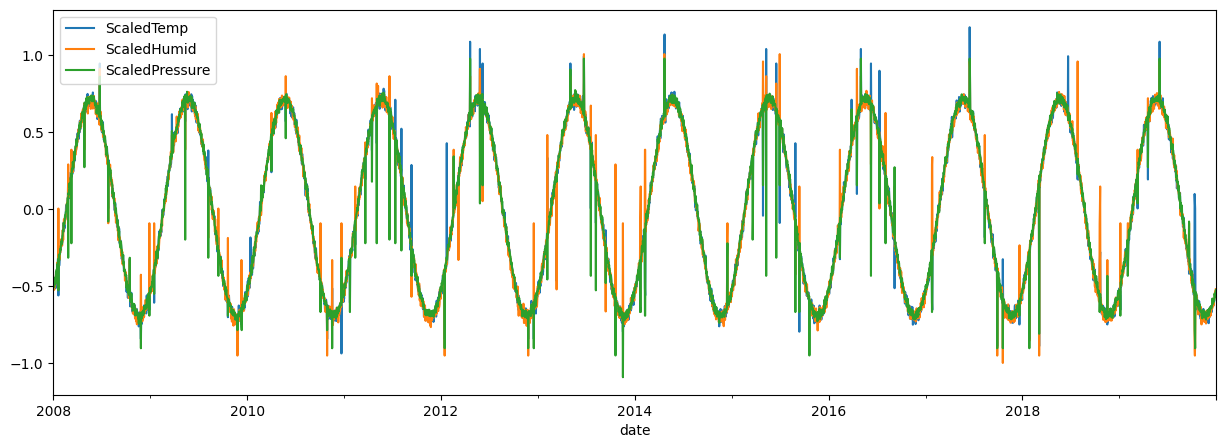

In [4]:
cols = ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']
train[cols].plot(figsize=(15,5))

<AxesSubplot: xlabel='date'>

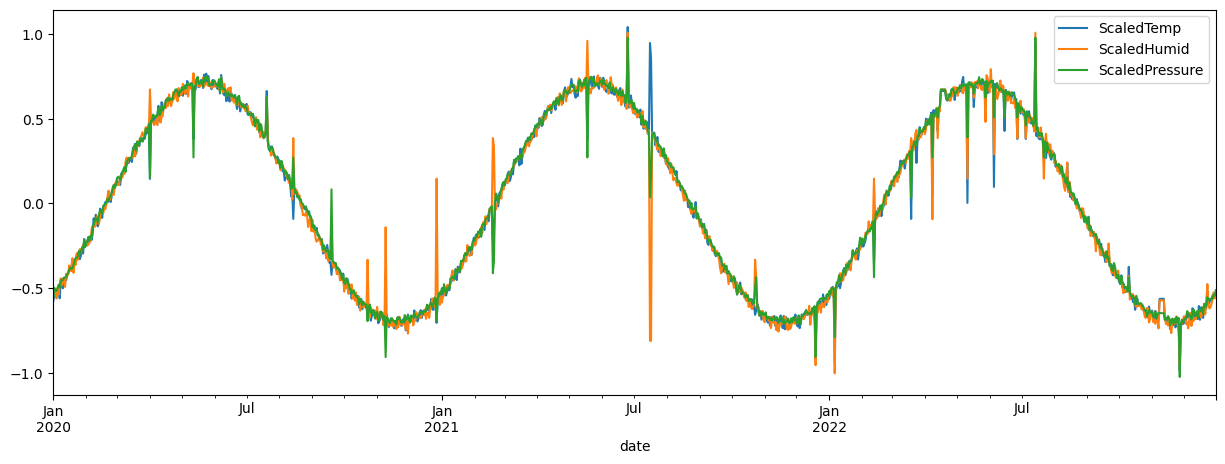

In [5]:
cols = ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']
test[cols].plot(figsize=(15,5))

In [6]:
df_combined=[train[cols],test[cols]]
df_combined=pd.concat(df_combined, axis=0)

In [7]:
for i in range(1, 8):
    df_combined[f'ST_t-{i}'] = df_combined['ScaledTemp'].shift(i)

In [8]:
for i in range(1, 8):
    df_combined[f'SH_t-{i}'] = df_combined['ScaledHumid'].shift(i)

In [9]:
for i in range(1, 8):
    df_combined[f'SP_t-{i}'] = df_combined['ScaledPressure'].shift(i)

In [10]:
df_combined = df_combined.dropna()

In [11]:
# Not on same scale and need to split the data to the train and test part 
nest_samples = 1096  # 1 year
train_data = df_combined.iloc[:-nest_samples].copy()
test_data = df_combined.iloc[-nest_samples:].copy()

In [12]:
features = [col for col in df_combined.columns if col not in ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']]

In [13]:
X_train, y_train = train_data[features], train_data[['ScaledTemp', 'ScaledHumid', 'ScaledPressure']] #Split into X and Y. training data.

In [14]:
x_test, y_test = test_data[features], test_data[['ScaledTemp', 'ScaledHumid', 'ScaledPressure']]

In [15]:
nest_samples=1096
le = LabelEncoder()

ground_truth = df_labeled.iloc[:, -1].values
ground_truth_train = ground_truth[:-nest_samples].copy()
ground_truth_test = ground_truth[-nest_samples:].copy()

ground_truth_train = le.fit_transform(ground_truth_train)
ground_truth_test = le.transform(ground_truth_test)

### GradientBoosting Model

In [16]:
gbr = GradientBoostingRegressor()
#n_estimators=100, learning_rate=0.05

In [17]:
models_gb = []
for i in range(3):
    model_gb = gbr
    model_gb.fit(X_train, y_train.iloc[:, i])
    models_gb.append(model_gb)

In [18]:
# Make predictions on the test set for each target variable
y_pred_train = []
for i in range(3):
    y_pred_train.append(models_gb[i].predict(X_train))

In [19]:
# Make predictions on the test set for each target variable
y_pred = []
for i in range(3):
    y_pred.append(models_gb[i].predict(x_test))

In [20]:
# Combine the predictions into a single dataframe on training prediction
df_prediction_train = pd.DataFrame({'Predicted_temperature': y_pred_train[0], 'Predicted_humidity': y_pred_train[1], 'Predicted_pressure': y_pred_train[2]}, index=X_train.index)

In [21]:
# Combine the predictions into a single dataframe
df_prediction = pd.DataFrame({'Predicted_temperature': y_pred[0], 'Predicted_humidity': y_pred[1], 'Predicted_pressure': y_pred[2]}, index=x_test.index)

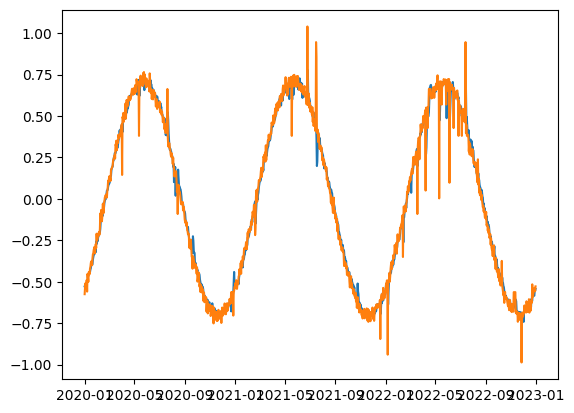

In [22]:
import matplotlib.pyplot as plt
plt.plot(df_prediction['Predicted_temperature'])
plt.plot(y_test['ScaledTemp'])
#plt.plot(df_prediction_train['Predicted_temperature'])

In [23]:
#test_data(predicted+actual)------>gb
data_temp_gbtest = pd.DataFrame({'predicted_temp': df_prediction['Predicted_temperature'], 'actual_temp': y_test['ScaledTemp']})
data_humidity_gbtest = pd.DataFrame({'predicted_humid': df_prediction['Predicted_humidity'], 'actual_humid': y_test['ScaledHumid']})
data_pressure_gbtest = pd.DataFrame({'predicted_pressure': df_prediction['Predicted_pressure'], 'actual_pressure': y_test['ScaledPressure']})
data_kNN_gbtest=pd.concat([data_temp_gbtest,data_humidity_gbtest,data_pressure_gbtest],axis=1)

In [24]:
classifier_name = 'KNN'
# model_knn = KNN()  # with default parameters.
modelgb_knn = KNN()

# Prediction on training data
modelgb_knn.fit(data_kNN_gbtest, y=None)  # y is ignored in unsupervised setting.
train_prediction_gb = modelgb_knn.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_gb_scores = modelgb_knn.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_gb = modelgb_knn.predict(data_kNN_gbtest) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_gb_scores = modelgb_knn.predict_proba(data_kNN_gbtest)[:,1]

### XGBOOST Model

In [25]:
xgb = XGBRegressor()
#n_estimators=100, learning_rate=0.05, random_state=42

In [26]:
models_xgb = []
for i in range(3):
    model_xgb = xgb
    model_xgb.fit(X_train, y_train.iloc[:, i])
    models_xgb.append(model_xgb)

In [27]:
# Make predictions on the test set for each target variable
y_pred = []
for i in range(3):
    y_pred.append(models_xgb[i].predict(x_test))

In [28]:
# Combine the predictions into a single dataframe
df_prediction = pd.DataFrame({'Predicted_temperature': y_pred[0], 'Predicted_humidity': y_pred[1], 'Predicted_pressure': y_pred[2]}, index=x_test.index)

In [29]:
# Make predictions on the test set for each target variable
y_pred_train = []
for i in range(3):
    y_pred_train.append(models_xgb[i].predict(X_train))

In [30]:
# Combine the predictions into a single dataframe on training prediction
df_prediction_train = pd.DataFrame({'Predicted_temperature': y_pred_train[0], 'Predicted_humidity': y_pred_train[1], 'Predicted_pressure': y_pred_train[2]}, index=X_train.index)

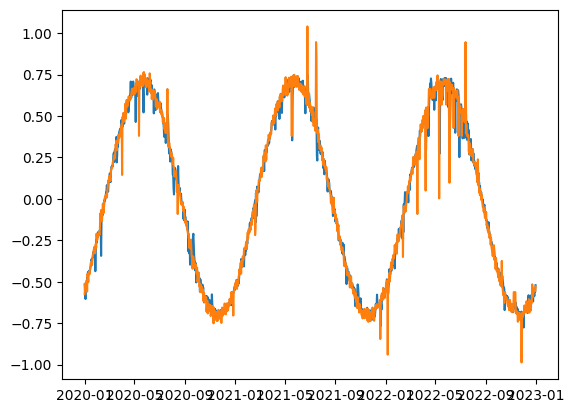

In [31]:
import matplotlib.pyplot as plt
plt.plot(df_prediction['Predicted_temperature'])
plt.plot(y_test['ScaledTemp'])

In [32]:
#test_data(Predicted+actual)-------->XGB
data_temp_xgbtest = pd.DataFrame({'predicted_temp': df_prediction['Predicted_temperature'], 'actual_temp': y_test['ScaledTemp'], 'residual_temp':(y_test['ScaledTemp'] - df_prediction['Predicted_temperature'])})
data_humidity_xgbtest = pd.DataFrame({'predicted_humid': df_prediction['Predicted_humidity'], 'actual_humid': y_test['ScaledHumid'], 'residual_humid':(y_test['ScaledHumid'] - df_prediction['Predicted_humidity'])})
data_pressure_xgbtest = pd.DataFrame({'predicted_pressure': df_prediction['Predicted_pressure'], 'actual_pressure': y_test['ScaledPressure'], 'residual_pressure':(y_test['ScaledPressure'] - df_prediction['Predicted_pressure'])})
data_kNN_xgbtest=pd.concat([data_temp_xgbtest,data_humidity_xgbtest,data_pressure_xgbtest],axis=1)

In [33]:
classifier_name = 'KNN'
# model_knn = KNN()  # with default parameters.
modelxgb_knn = KNN()

# Prediction on training data
modelxgb_knn.fit(data_kNN_xgbtest, y=None)  # y is ignored in unsupervised setting.
train_prediction_xgb = modelxgb_knn.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_xgb_scores = modelxgb_knn.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_xgb = modelxgb_knn.predict(data_kNN_xgbtest) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_xgb_scores = modelxgb_knn.predict_proba(data_kNN_xgbtest)[:,1]

### RandomForest Model

In [34]:
rf = RandomForestRegressor()
#n_estimators=100, random_state=42

In [35]:
models_rf = []
for i in range(3):
    model_rf = rf
    model_rf.fit(X_train, y_train.iloc[:, i])
    models_rf.append(model_rf)

In [36]:
# Make predictions on the test set for each target variable
y_pred_train = []
for i in range(3):
    y_pred_train.append(models_rf[i].predict(X_train))

In [37]:
# Make predictions on the test set for each target variable
y_pred = []
for i in range(3):
    y_pred.append(models_rf[i].predict(x_test))

In [38]:
# Combine the predictions into a single dataframe on training prediction
df_prediction_train = pd.DataFrame({'Predicted_temperature': y_pred_train[0], 'Predicted_humidity': y_pred_train[1], 'Predicted_pressure': y_pred_train[2]}, index=X_train.index)

In [39]:
# Combine the predictions into a single dataframe
df_prediction = pd.DataFrame({'Predicted_temperature': y_pred[0], 'Predicted_humidity': y_pred[1], 'Predicted_pressure': y_pred[2]}, index=x_test.index)

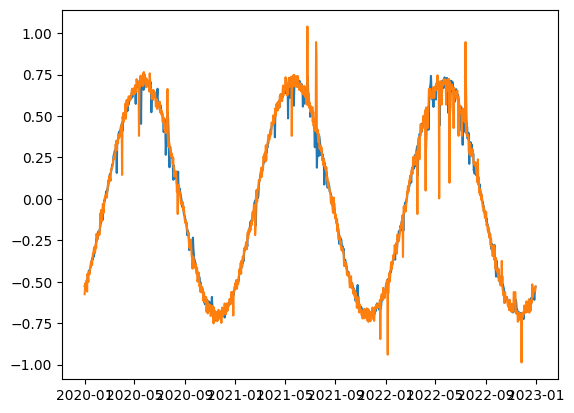

In [40]:
import matplotlib.pyplot as plt
plt.plot(df_prediction['Predicted_temperature'])
plt.plot(y_test['ScaledTemp'])
#plt.plot(df_prediction_train['Predicted_temperature'])

In [41]:
#test_data(Predicted+actual)
data_temp_rftest = pd.DataFrame({'predicted_temp': df_prediction['Predicted_temperature'], 'actual_temp': y_test['ScaledTemp']})
data_humidity_rftest = pd.DataFrame({'predicted_humid': df_prediction['Predicted_humidity'], 'actual_humid': y_test['ScaledHumid']})
data_pressure_rftest = pd.DataFrame({'predicted_pressure': df_prediction['Predicted_pressure'], 'actual_pressure': y_test['ScaledPressure']})
data_kNN_rftest=pd.concat([data_temp_rftest,data_humidity_rftest,data_pressure_rftest],axis=1)

In [42]:
classifier_name = 'KNN'
# model_knn = KNN()  # with default parameters.
modelrf_knn = KNN()

# Prediction on training data
modelrf_knn.fit(data_kNN_rftest, y=None)  # y is ignored in unsupervised setting.
train_prediction_rf = modelrf_knn.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_rf_scores = modelrf_knn.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_rf = modelrf_knn.predict(data_kNN_rftest) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_rf_scores = modelrf_knn.predict_proba(data_kNN_rftest)[:,1]

### SVR Model

In [43]:
svr = SVR()

In [44]:
models_svr = []
for i in range(3):
    model_svr = svr
    model_svr.fit(X_train, y_train.iloc[:, i])
    models_svr.append(model_svr)

In [45]:
# Make predictions on the test set for each target variable
y_pred_train = []
for i in range(3):
    y_pred_train.append(models_svr[i].predict(X_train))

In [46]:
# Make predictions on the test set for each target variable
y_pred = []
for i in range(3):
    y_pred.append(models_svr[i].predict(x_test))

In [47]:
# Combine the predictions into a single dataframe on training prediction
df_prediction_train = pd.DataFrame({'Predicted_temperature': y_pred_train[0], 'Predicted_humidity': y_pred_train[1], 'Predicted_pressure': y_pred_train[2]}, index=X_train.index)

In [48]:
# Combine the predictions into a single dataframe
df_prediction = pd.DataFrame({'Predicted_temperature': y_pred[0], 'Predicted_humidity': y_pred[1], 'Predicted_pressure': y_pred[2]}, index=x_test.index)

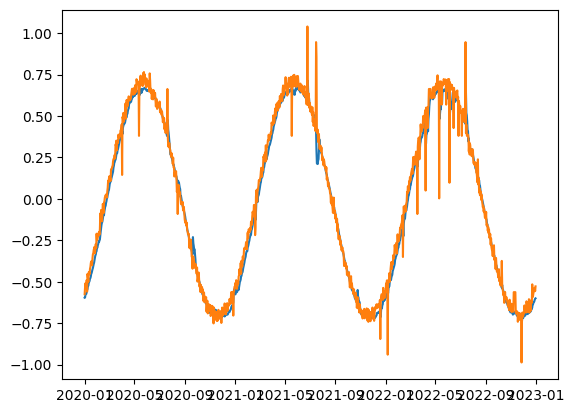

In [49]:
import matplotlib.pyplot as plt
plt.plot(df_prediction['Predicted_temperature'])
plt.plot(y_test['ScaledTemp'])
#plt.plot(df_prediction_train['Predicted_temperature'])

In [50]:
#test_data(prediction+actual)
data_temp_svrtest = pd.DataFrame({'predicted_temp': df_prediction['Predicted_temperature'], 'actual_temp': y_test['ScaledTemp']})
data_humidity_svrtest = pd.DataFrame({'predicted_humid': df_prediction['Predicted_humidity'], 'actual_humid': y_test['ScaledHumid']})
data_pressure_svrtest = pd.DataFrame({'predicted_pressure': df_prediction['Predicted_pressure'], 'actual_pressure': y_test['ScaledPressure']})
data_kNN_svrtest=pd.concat([data_temp_svrtest,data_humidity_svrtest,data_pressure_svrtest],axis=1)

In [51]:
classifier_name = 'KNN'
# model_knn = KNN()  # with default parameters.
modelsvr_knn = KNN()

# Prediction on training data
modelsvr_knn.fit(data_kNN_svrtest, y=None)  # y is ignored in unsupervised setting.
train_prediction_svr = modelsvr_knn.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_svr_scores = modelsvr_knn.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction_svr = modelsvr_knn.predict(data_kNN_svrtest) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_svr_scores = modelsvr_knn.predict_proba(data_kNN_svrtest)[:,1]

### Evaluation on AUC-ROC

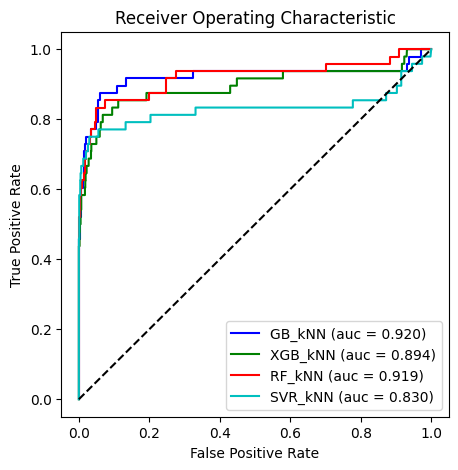

In [52]:
# Calculate AUC-ROC score
auc_roc_gb = roc_auc_score(ground_truth_test, test_prediction_gb_scores)
fpr_gb, tpr_gb, thresholds_gb = roc_curve(ground_truth_test, test_prediction_gb_scores)
auc_kNN_gb = auc(fpr_gb,tpr_gb)

auc_roc_xgb = roc_auc_score(ground_truth_test, test_prediction_xgb_scores)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(ground_truth_test, test_prediction_xgb_scores)
auc_kNN_xgb = auc(fpr_xgb,tpr_xgb)

auc_roc_rf = roc_auc_score(ground_truth_test, test_prediction_rf_scores)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(ground_truth_test, test_prediction_rf_scores)
auc_kNN_rf = auc(fpr_rf,tpr_rf)

auc_roc_svr = roc_auc_score(ground_truth_test, test_prediction_svr_scores)
fpr_svr, tpr_svr, thresholds_svr = roc_curve(ground_truth_test, test_prediction_svr_scores)
auc_kNN_svr = auc(fpr_svr,tpr_svr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr_gb, tpr_gb, linestyle='-', color='b', label='GB_kNN (auc = %0.3f)' % auc_kNN_gb)

#plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr_xgb, tpr_xgb, linestyle='-', color='g', label='XGB_kNN (auc = %0.3f)' % auc_kNN_xgb)

#plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr_rf, tpr_rf, linestyle='-', color='r', label='RF_kNN (auc = %0.3f)' % auc_kNN_rf)

#plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr_svr, tpr_svr, linestyle='-', color='c', label='SVR_kNN (auc = %0.3f)' % auc_kNN_svr)


plt.plot([0, 1], [0, 1], 'k--')  # Random ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
#GB and RF worked better.

### Evaluation Confusion Matrix

In [53]:
#GB Confusion Matrix.
from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, modelgb_knn.predict(data_kNN_gbtest))

array([[992,  56],
       [ 10,  38]], dtype=int64)

In [54]:
# XGB Confusion Matrix.
from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, modelxgb_knn.predict(data_kNN_xgbtest))

array([[994,  54],
       [ 12,  36]], dtype=int64)

In [55]:
# RF Confusion Matrix.
from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, modelrf_knn.predict(data_kNN_rftest))

array([[995,  53],
       [  8,  40]], dtype=int64)

In [56]:
# SVR Confusion Matrix.
from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, modelsvr_knn.predict(data_kNN_svrtest))

array([[993,  55],
       [ 12,  36]], dtype=int64)

### Evaluation RMS and MAE Score

In [57]:
#GB
print("\nOn Test Data:")
evaluate_print(classifier_name, ground_truth_test, test_prediction_gb_scores)
unique, counts = np.unique(test_prediction_gb, return_counts=True)
print("\nOutlier prediction information on Test Data:", len(data_kNN_gbtest), dict(zip(unique, counts)))
# no of errors in test set
number_of_errors = (test_prediction_gb != ground_truth_test).sum()
print('No of Errors in test set: {}'.format(number_of_errors))
rms = mean_squared_error(ground_truth_test, test_prediction_gb, squared=False)
mae = mean_absolute_error(ground_truth_test, test_prediction_gb)
print('\nRMS on Test Set :',rms)
print('\nMAE on Test Set :',mae)


On Test Data:
KNN ROC:0.9199, precision @ rank n:0.6875

Outlier prediction information on Test Data: 1096 {0: 1002, 1: 94}
No of Errors in test set: 66

RMS on Test Set : 0.24539555436517138

MAE on Test Set : 0.060218978102189784


In [58]:
#XGB
print("\nOn Test Data:")
evaluate_print(classifier_name, ground_truth_test, test_prediction_xgb_scores)
unique, counts = np.unique(test_prediction_xgb, return_counts=True)
print("\nOutlier prediction information on Test Data:", len(data_kNN_xgbtest), dict(zip(unique, counts)))
# no of errors in test set
number_of_errors = (test_prediction_xgb != ground_truth_test).sum()
print('No of Errors in test set: {}'.format(number_of_errors))
rms = mean_squared_error(ground_truth_test, test_prediction_xgb, squared=False)
mae = mean_absolute_error(ground_truth_test, test_prediction_xgb)
print('\nRMS on Test Set :',rms)
print('\nMAE on Test Set :',mae)


On Test Data:
KNN ROC:0.8944, precision @ rank n:0.6042

Outlier prediction information on Test Data: 1096 {0: 1006, 1: 90}
No of Errors in test set: 66

RMS on Test Set : 0.24539555436517138

MAE on Test Set : 0.060218978102189784


In [59]:
#RF
print("\nOn Test Data:")
evaluate_print(classifier_name, ground_truth_test, test_prediction_rf_scores)
unique, counts = np.unique(test_prediction_rf, return_counts=True)
print("\nOutlier prediction information on Test Data:", len(data_kNN_rftest), dict(zip(unique, counts)))
# no of errors in test set
number_of_errors = (test_prediction_rf != ground_truth_test).sum()
print('No of Errors in test set: {}'.format(number_of_errors))
rms = mean_squared_error(ground_truth_test, test_prediction_rf, squared=False)
mae = mean_absolute_error(ground_truth_test, test_prediction_rf)
print('\nRMS on Test Set :',rms)
print('\nMAE on Test Set :',mae)


On Test Data:
KNN ROC:0.9194, precision @ rank n:0.6458

Outlier prediction information on Test Data: 1096 {0: 1003, 1: 93}
No of Errors in test set: 61

RMS on Test Set : 0.2359172191820032

MAE on Test Set : 0.055656934306569344


In [60]:
#SVR
print("\nOn Test Data:")
evaluate_print(classifier_name, ground_truth_test, test_prediction_svr_scores)
unique, counts = np.unique(test_prediction_svr, return_counts=True)
print("\nOutlier prediction information on Test Data:", len(data_kNN_svrtest), dict(zip(unique, counts)))
# no of errors in test set
number_of_errors = (test_prediction_svr != ground_truth_test).sum()
print('No of Errors in test set: {}'.format(number_of_errors))
rms = mean_squared_error(ground_truth_test, test_prediction_svr, squared=False)
mae = mean_absolute_error(ground_truth_test, test_prediction_svr)
print('\nRMS on Test Set :',rms)
print('\nMAE on Test Set :',mae)


On Test Data:
KNN ROC:0.8305, precision @ rank n:0.6875

Outlier prediction information on Test Data: 1096 {0: 1005, 1: 91}
No of Errors in test set: 67

RMS on Test Set : 0.24724762255947755

MAE on Test Set : 0.06113138686131387
